In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from nltk import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [2]:
# load corpus 
df = pd.read_pickle("barbara_dreams.pkl")
df = df.sample(frac=1,random_state=0).reset_index(drop=True).copy()
# separamos entre train y test sets
X = df.sueño
y = df.tag
X_train_text, X_test_text, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.20, random_state=1234)

In [3]:
# Limpieza del texto
def clean_text(text):
    text = re.sub('(\[")|("\])'," ",text)
    return text.lower().strip()
# Tokenizador
def tokenizer(text):
    return [w for w in word_tokenize(text) if w.isalpha() and len(w)>1]


# Features 


In [4]:
# incluyo bigramas (aclaracion:si aparece "best friend" tambien va a contar para "best" y para "friend")
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=tokenizer, min_df=5,stop_words="english",ngram_range=(1,2))
X_train = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
X_test = count_vect.transform(X_test_text) # cuenta frecuencia de tokens existentes en el diccionario


# Naive Bayes

In [5]:
clf_MNB = MultinomialNB()
# Parametros a variar 
parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_MNB = GridSearchCV(clf_MNB, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_MNB.fit(X_train, y_train)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_MNB = grid_search_MNB.best_estimator_
print ("alpha:",best_clf_MNB.alpha )
print("fscore_cv=",grid_search_MNB.cv_results_["mean_test_score"].max())

alpha: 1
fscore_cv= 0.809999918378


In [6]:
# Resultados del greed search
grid_search_MNB.cv_results_

{'mean_fit_time': array([ 0.0171773 ,  0.01718314,  0.01718366,  0.01562147,  0.01562078,
         0.01249692,  0.02343264,  0.01562083,  0.0140588 ]),
 'mean_score_time': array([ 0.00312433,  0.00781064,  0.00468643,  0.0046864 ,  0.00312409,
         0.00312428,  0.        ,  0.00156231,  0.        ]),
 'mean_test_score': array([ 0.74011322,  0.74802086,  0.76254817,  0.77267952,  0.79062934,
         0.80039044,  0.80999992,  0.79412483,  0.65032182]),
 'mean_train_score': array([ 0.94972957,  0.94966516,  0.94947163,  0.94875433,  0.94773007,
         0.94485732,  0.94016474,  0.91771918,  0.75126517]),
 'param_alpha': masked_array(data = [0.001 0.003 0.01 0.03 0.1 0.3 1 3 10],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': ({'alpha': 0.001},
  {'alpha': 0.003},
  {'alpha': 0.01},
  {'alpha': 0.03},
  {'alpha': 0.1},
  {'alpha': 0.3},
  {'alpha': 1},
  {'alpha': 3},
  {'alpha': 10}),
 'rank_test_score': array([8, 7,

NameError: name 'MNB_score' is not defined

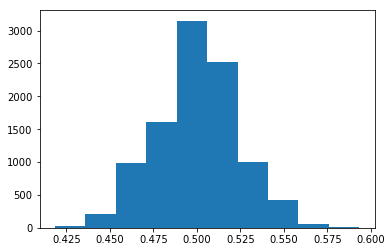

In [7]:
# comparo mi Score con lo esperado por azar
import random
f_measure_random = [f1_score(list(y_test), random.sample(list(y_test), len(y_test)), average="macro") for i in range(10000)]
# Histograma
histograma = plt.hist(f_measure_random)
plt.vlines(MNB_score,ymin=0,ymax=histograma[0].max())
plt.title("p-val="+str((f_measure_random>MNB_score).sum()/len(f_measure_random)))

# Random Forest

In [8]:
clf_RF = RandomForestClassifier(class_weight="balanced",random_state=123)
# Parametros a variar 
parameters = {'n_estimators':[200],'max_features': [10,20,'auto'],"max_depth":[5,10,None] }
# define un grid search a realizar 
grid_search_RF = GridSearchCV(clf_RF, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_RF.fit(X_train, y_train)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_RF = grid_search_RF.best_estimator_
print ("n_estimators:",best_clf_RF.n_estimators,"; max_features:",best_clf_RF.max_features,"; max_depth:",best_clf_RF.max_depth )
print("fscore_cv=",grid_search_RF.cv_results_["mean_test_score"].max())

n_estimators: 200 ; max_features: auto ; max_depth: 10
fscore_cv= 0.761409772177


# Feature Importance

(array([ 0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,  0.035]),
 <a list of 8 Text yticklabel objects>)

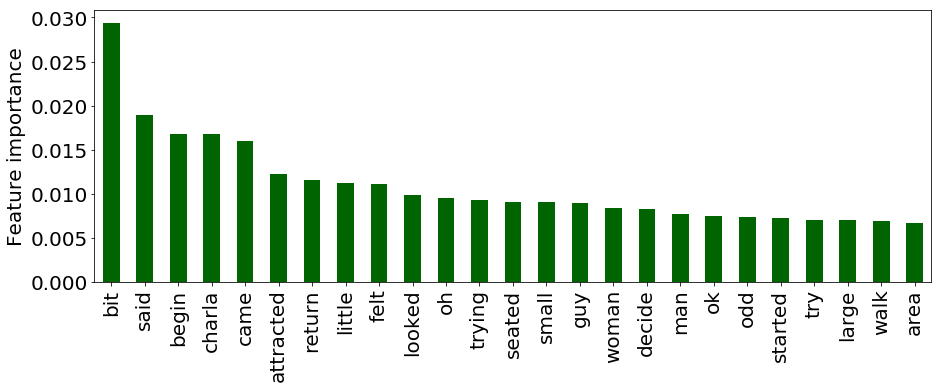

In [9]:
important_words = pd.Series(best_clf_RF.feature_importances_,index=count_vect.get_feature_names()).sort_values(ascending=False)[:25]
important_words.plot(kind="bar",figsize=(15,5),color="darkgreen")
plt.ylabel("Feature importance",size=20);plt.xticks(size = 20);plt.yticks(size = 20)

In [10]:
#quiero ver como se distribuyen estas palabras entre las clases:
#feature_log_prob_=log(P(w|c))
df_probas = pd.DataFrame(np.transpose(np.exp(best_clf_MNB.feature_log_prob_)),index=count_vect.get_feature_names(),columns=best_clf_MNB.classes_)
df_probas.head()

0-40  50-adelante
abandon    0.000065     0.000052
abandoned  0.000043     0.000104
ability    0.000043     0.000052
able       0.000345     0.000416
abner      0.000216     0.000125

(array([ 0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ,  0.012]),
 <a list of 7 Text yticklabel objects>)

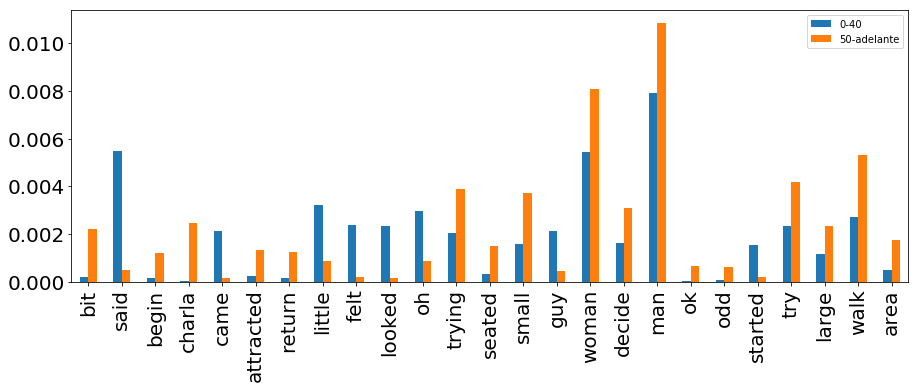

In [11]:
df_probas.loc[important_words.index].plot(kind="bar",figsize=(15,5))
plt.xticks(size = 20);plt.yticks(size = 20)

# TF-IDF
### ejemplo

In [12]:
vectorizer = TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer)

In [13]:
train_text = ["mono mono cabra","mono mono elefante","mono mono","mono mono mono mono","mono","mono","elefante"]

In [14]:
tfidf = vectorizer.fit_transform(train_text)

In [15]:
print(vectorizer.get_feature_names())

['cabra', 'elefante', 'mono']


In [16]:
tfidf.toarray()

array([[ 0.72498682,  0.        ,  0.68876274],
       [ 0.        ,  0.65796814,  0.75304577],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ]])

In [17]:
vectorizer.idf_

array([ 2.38629436,  1.98082925,  1.13353139])

In [18]:
vectorizer.transform(["mono cabra","mono cabra elefante","perro mono"]).toarray()

array([[ 0.90327141,  0.        ,  0.42906965],
       [ 0.72268898,  0.59989392,  0.34328986],
       [ 0.        ,  0.        ,  1.        ]])

## Volviendo a los sueños
### OJO: las técnicas de preprocesamiento que aprendan de los datos (como el tf-idf) deben incluirse dentro de un pipeline para no hacer "trampa" en el Cross-Validation 
#### Niave Bayes

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
pipeline = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer,stop_words="english",ngram_range=(1,2))),
                     ('clf',  MultinomialNB())])
# Parametros a variar 
parameters = {'tfidf__use_idf': [True, False],
              'tfidf__min_df': [5, 10],
              'clf__alpha': [0.1,1]}
clf_pipe = GridSearchCV(pipeline, parameters, scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
 
# Fit and tune model
clf_pipe.fit(X_train_text, y_train)

In [ ]:
best_pipeline = clf_pipe.best_estimator_
print("Best score:",clf_pipe.best_score_)
print("\nBest parameters set:")
best_parameters = best_pipeline.get_params()
print("use idf:",best_parameters["tfidf__use_idf"])
print("RF max_features:",best_parameters["tfidf__min_df"])
print("RF max_depth:",best_parameters["clf__alpha"])

#### Con random Forest

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
pipeline = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer,stop_words="english",ngram_range=(1,2))),
                     ('clf',  RandomForestClassifier())])
# Parametros a variar 
parameters = {'tfidf__use_idf': [True, False],
              'tfidf__min_df': [5, 10],
              'clf__n_estimators': [200],
             }
clf_pipe_RF = GridSearchCV(pipeline, parameters, scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# Fit and tune model
clf_pipe_RF.fit(X_train_text, y_train)
best_pipeline_RF = clf_pipe_RF.best_estimator_
print("Best score:",clf_pipe_RF.best_score_)
print("\nBest parameters set:")
best_parameters = best_pipeline_RF.get_params()
print("use idf:",best_parameters["tfidf__use_idf"])
print("RF max_features:",best_parameters["tfidf__min_df"])

## Ahora con un paso de selección de variables

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Defino el pipeline
pipeline = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer, min_df=5,stop_words="english")),
                     ('reduce_dim', SelectKBest(mutual_info_classif)),
                     ('clf', RandomForestClassifier(n_estimators=200,random_state=123))])

parameters = {'tfidf__ngram_range': [(1, 2)],'reduce_dim__k':(100,"all")}

# Fit and tune model
clf_pipe_feature_sel = GridSearchCV(pipeline, parameters, cv=10)
clf_pipe_feature_sel.fit(X_train_text, y_train)

In [ ]:
best_pipeline_feature_sel = clf_pipe_feature_sel.best_estimator_
print("Best Cross-Validation:",clf_pipe_feature_sel.best_score_)
print("\nBest parameters set:")
best_parameters = best_pipeline_feature_sel.get_params()
print("dims:",best_parameters["reduce_dim__k"])
print("RF max_features:",best_parameters["clf__max_features"])
print("RF max_depth:",best_parameters["clf__max_depth"])

# Performance en el Test Set

In [ ]:
print("Naive Bayes word-count = ", f1_score(y_test, grid_search_MNB.predict(X_test), average="macro"))
print("Random Fores word-count = ", f1_score(y_test, grid_search_RF.predict(X_test), average="macro"))
# ver que el input del Pipeline son los textos, ya que incluye el paso de extracción de Features
print("Naive Bayes tf-idf = ", f1_score(y_test, best_pipeline.predict(X_test_text), average="macro"))
print("Random Forest tf-idf = ", f1_score(y_test, best_pipeline_RF.predict(X_test_text), average="macro"))